# Notebook outlook
- The goal of this notebook is to perform analysis for most informative temporal delays in hippocampal spike trains.
- The approach is similar to the previous work:
    1. Find the distribution of baseline mutual information between each neuron and location from the hc3 dataset.
    1. Determine the mutual information between neural spiking and location for each neuron for a given temporal delay in spike train.
    1. Determine the *p-value* depending on the location of this information on the distribution.
    1. Find the temporal delay that gives the minimum *p-value* i.e. the most stastically significant value for information.

In [77]:
import os
import sys
import numpy as np
from numpy.random import shuffle, default_rng, normal, choice
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import seaborn as sns
import pandas as pd
from scipy.stats import gamma, invgamma, gaussian_kde, lognorm
from scipy.stats import norm as gauss
from numpy.linalg import norm
from tqdm import tqdm

from helper_functions_hc3_preprocessing import * 
from helper_functions_circuit_MI import *

plt.rcParams['font.sans-serif'] = 'Arial'
fontdict = {'fontsize':16}
labeldict = {'labelsize':14}

# This option supresses chained assignment warnings: Be careful with using chanied assignments in this
pd.set_option('mode.chained_assignment', None)

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Text(0.5, 0, 'x')

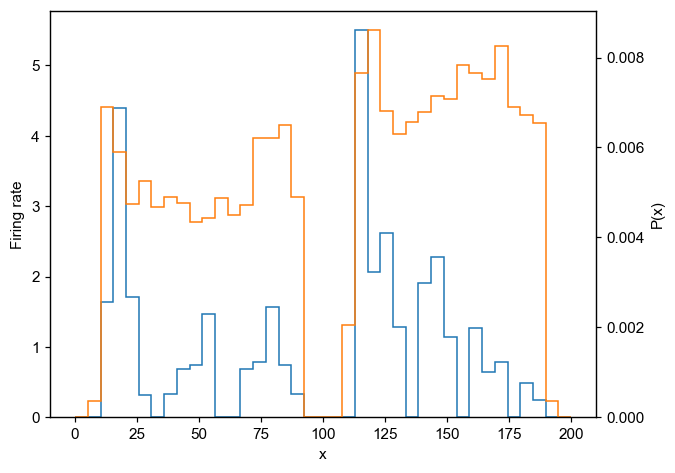

In [42]:
# pilot run for bootstrap analysis
rate_ca3, p_ca3, bins_spikes_ca3 = firing_rate_location_data('gor01', 3, 4, 4, 0)

# plot the above
fig, ax = plt.subplots(dpi=110)
ax2 = ax.twinx()
ax.stairs(rate_ca3, bins_spikes_ca3, label=r'$\lambda(x)$')
ax2.stairs(p_ca3, bins_spikes_ca3, label=r'$p(x)$', color='C1')
ax.set_ylabel('Firing rate')
ax2.set_ylabel('P(x)')
ax.set_xlabel('x')

Text(0.5, 0, 'x')

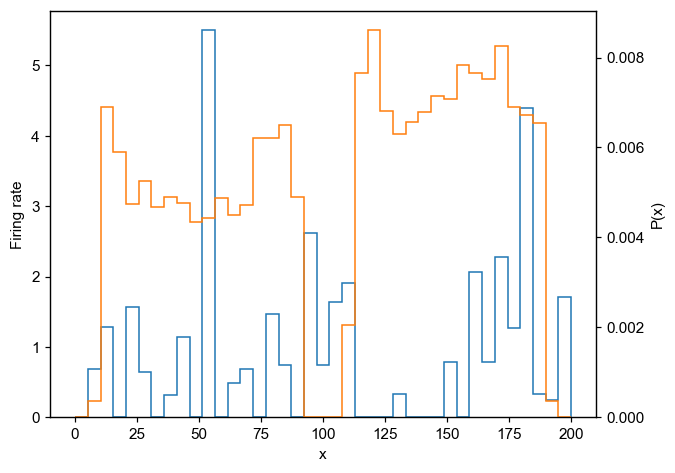

In [43]:
# shuffle rate_ca3
idx = choice(len(rate_ca3), len(rate_ca3), replace=False)
sh_rate_ca3 = rate_ca3[idx]

fig, ax = plt.subplots(dpi=110)
ax2 = ax.twinx()
ax.stairs(sh_rate_ca3, bins_spikes_ca3, label=r'$\lambda(x)$')
ax2.stairs(p_ca3, bins_spikes_ca3, label=r'$p(x)$', color='C1')
ax.set_ylabel('Firing rate')
ax2.set_ylabel('P(x)')
ax.set_xlabel('x')

In [83]:
# generate a bootstrap array
# bootstrap_arr_ca3 = 1000 x number of CA3 neurons array

## number of bootstrap points
bootstrap_itr = 1000

## initialize the array to store the results
bootstrap_arr_ca3 = np.empty((bootstrap_itr, total_pyramidal_neurons('gor01')))

## pick neurons
ca3_neurons = pick_random_neurons(1, 'gor01')

## initialize two for loops and apply bootstrap
for j, n in enumerate(ca3_neurons):
    # find the rate and probability arrays
    rx, px, bins = firing_rate_location_data('gor01', n, 4, 4)
    for i in range(bootstrap_itr):
        print(f'Neuron: {j}, Iteration: {i}')

        # generate shuffled indices
        sh_idx = choice(len(rx), len(rx), replace=True) # keep replace=True for bootstrap analysis
        sh_rx = rx[sh_idx]

        # compute information between shuffled array and location
        mi = skaggs_MI(sh_rx, px)

        # append to the array
        bootstrap_arr_ca3[i, j] = mi

        # save into a csv file
        np.savetxt(FIL_DATA_PATH+'ca3_bootstrap_data_6_20_23.csv', bootstrap_arr_ca3, delimiter=',', newline='\n')




Neuron: 0, Iteration: 0
Neuron: 0, Iteration: 1
Neuron: 0, Iteration: 2
Neuron: 0, Iteration: 3
Neuron: 0, Iteration: 4
Neuron: 0, Iteration: 5
Neuron: 0, Iteration: 6
Neuron: 0, Iteration: 7
Neuron: 0, Iteration: 8
Neuron: 0, Iteration: 9
Neuron: 0, Iteration: 10
Neuron: 0, Iteration: 11
Neuron: 0, Iteration: 12
Neuron: 0, Iteration: 13
Neuron: 0, Iteration: 14
Neuron: 0, Iteration: 15
Neuron: 0, Iteration: 16
Neuron: 0, Iteration: 17
Neuron: 0, Iteration: 18
Neuron: 0, Iteration: 19
Neuron: 0, Iteration: 20
Neuron: 0, Iteration: 21
Neuron: 0, Iteration: 22
Neuron: 0, Iteration: 23
Neuron: 0, Iteration: 24
Neuron: 0, Iteration: 25
Neuron: 0, Iteration: 26
Neuron: 0, Iteration: 27
Neuron: 0, Iteration: 28
Neuron: 0, Iteration: 29
Neuron: 0, Iteration: 30
Neuron: 0, Iteration: 31
Neuron: 0, Iteration: 32
Neuron: 0, Iteration: 33
Neuron: 0, Iteration: 34
Neuron: 0, Iteration: 35
Neuron: 0, Iteration: 36
Neuron: 0, Iteration: 37
Neuron: 0, Iteration: 38
Neuron: 0, Iteration: 39
Neuron: 0,

In [143]:
## USE THIS CELL TO RUN THE SAME ANALYSIS FOR CA1   
## number of bootstrap points
bootstrap_itr = 1000

## initialize the array to store the results
bootstrap_arr_ca1 = np.empty((bootstrap_itr, total_pyramidal_neurons('ec014')))

## pick neurons
ca1_neurons = pick_random_neurons(1, 'ec014')

## initialize two for loops and apply bootstrap
for j, n in enumerate(ca1_neurons):
    # find the rate and probability arrays
    rx, px, bins = firing_rate_location_data('ec014', n, 4, 4)
    for i in range(bootstrap_itr):
        print(f'Neuron: {j}, Iteration: {i}')

        # generate shuffled indices
        sh_idx = choice(len(rx), len(rx), replace=True) # keep replace=True for bootstrap analysis
        sh_rx = rx[sh_idx]

        # compute information between shuffled array and location
        mi = skaggs_MI(sh_rx, px)

        # append to the array
        bootstrap_arr_ca1[i, j] = mi

        # save into a csv file
        np.savetxt(FIL_DATA_PATH+'ca1_bootstrap_data_7_24_23.csv', bootstrap_arr_ca1, delimiter=',', newline='\n')

Neuron: 0, Iteration: 0
Neuron: 0, Iteration: 1
Neuron: 0, Iteration: 2
Neuron: 0, Iteration: 3
Neuron: 0, Iteration: 4
Neuron: 0, Iteration: 5
Neuron: 0, Iteration: 6
Neuron: 0, Iteration: 7
Neuron: 0, Iteration: 8
Neuron: 0, Iteration: 9
Neuron: 0, Iteration: 10
Neuron: 0, Iteration: 11
Neuron: 0, Iteration: 12
Neuron: 0, Iteration: 13
Neuron: 0, Iteration: 14
Neuron: 0, Iteration: 15
Neuron: 0, Iteration: 16
Neuron: 0, Iteration: 17
Neuron: 0, Iteration: 18
Neuron: 0, Iteration: 19
Neuron: 0, Iteration: 20
Neuron: 0, Iteration: 21
Neuron: 0, Iteration: 22
Neuron: 0, Iteration: 23
Neuron: 0, Iteration: 24
Neuron: 0, Iteration: 25
Neuron: 0, Iteration: 26
Neuron: 0, Iteration: 27
Neuron: 0, Iteration: 28
Neuron: 0, Iteration: 29
Neuron: 0, Iteration: 30
Neuron: 0, Iteration: 31
Neuron: 0, Iteration: 32
Neuron: 0, Iteration: 33
Neuron: 0, Iteration: 34
Neuron: 0, Iteration: 35
Neuron: 0, Iteration: 36
Neuron: 0, Iteration: 37
Neuron: 0, Iteration: 38
Neuron: 0, Iteration: 39
Neuron: 0,

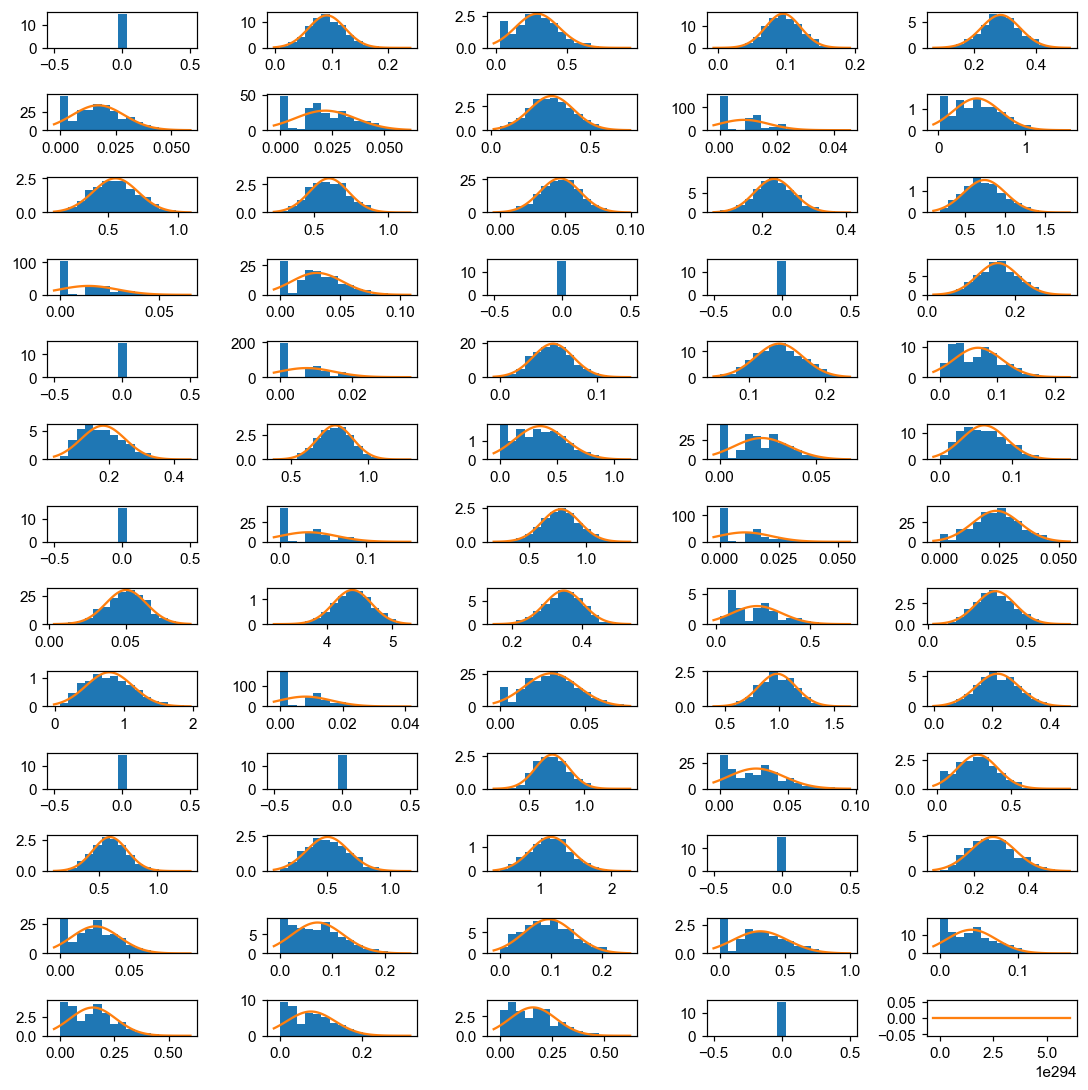

In [111]:
## plotting the distributions CA3
fig, ax = plt.subplots(13, 5, dpi=110, figsize=(10,10))
axs = ax.ravel()

# initiate a for loop over 2nd dimension of the array
for i in range(bootstrap_arr_ca3.shape[1]):
    # fit a gaussian to the bootstrap datapoints for i-th neuron
    mean, sd = gauss.fit(bootstrap_arr_ca3[:, i])

    # plot the histogram
    h, _, _ = axs[i].hist(bootstrap_arr_ca3[:, i], bins=15, density=True)
    xmin, xmax = axs[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    fit_plot = gauss.pdf(x, mean, sd)
    axs[i].plot(x, fit_plot)
    
    # labeling
    # axs[i].set_xlabel('Mutual Information: location & spiking (bits/s)')
    # axs[i].set_ylabel('Densty')

fig.tight_layout()


In [224]:
bootstrap_arr_ca1.shape

(1000, 71)

/home/vjaltare/anaconda3/envs/sequences/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


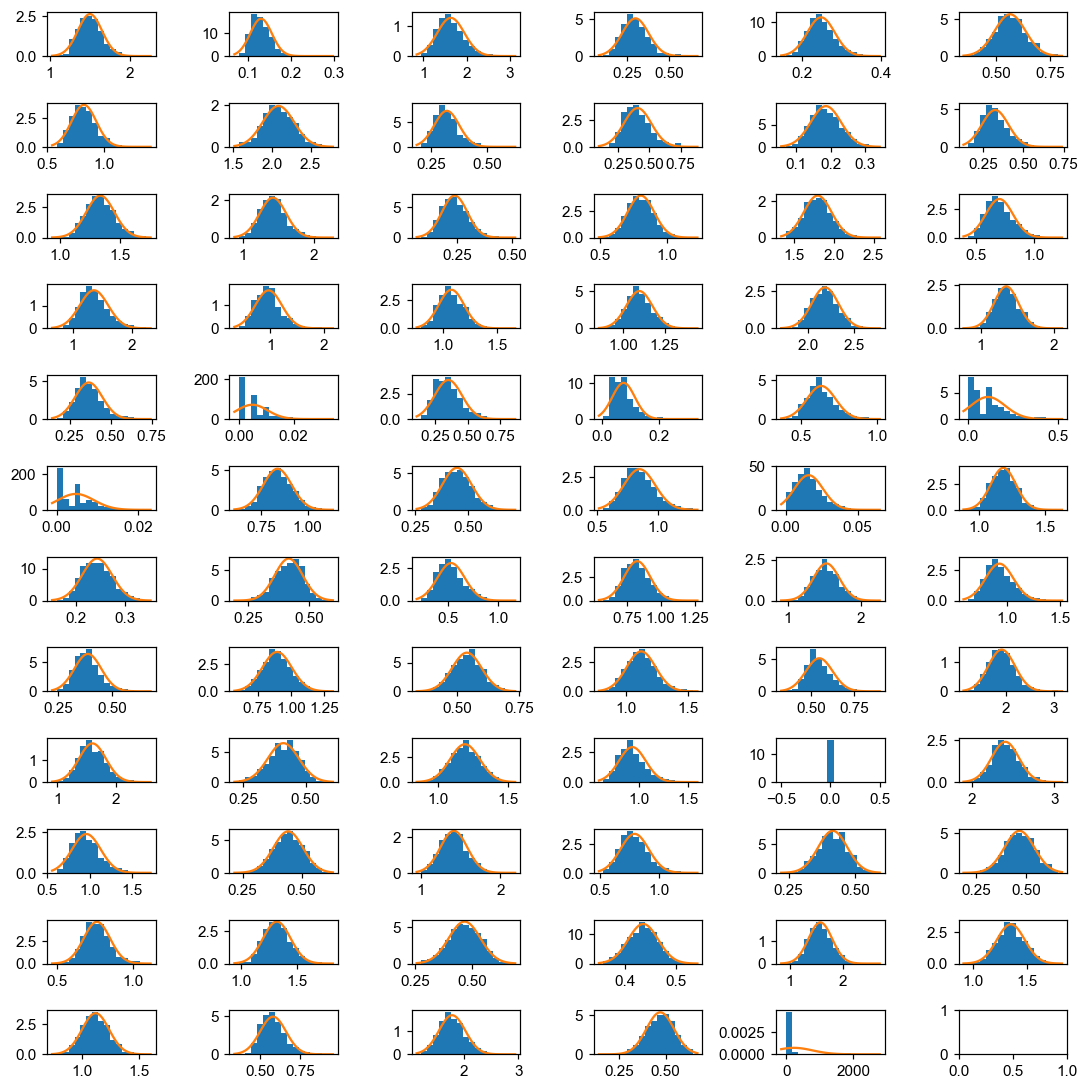

In [225]:
## plotting the distributions CA1
fig, ax = plt.subplots(12, 6, dpi=110, figsize=(10,10))
axs = ax.ravel()

bootstrap_arr_ca1 = np.genfromtxt('ca1_bootstrap_data_7_24_23.csv', delimiter=',')

# initiate a for loop over 2nd dimension of the array
for i in range(bootstrap_arr_ca1.shape[1]):
    # fit a gaussian to the bootstrap datapoints for i-th neuron
    mean, sd = gauss.fit(bootstrap_arr_ca1[:, i])

    # plot the histogram
    h, _, _ = axs[i].hist(bootstrap_arr_ca1[:, i], bins=15, density=True)
    xmin, xmax = axs[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    fit_plot = gauss.pdf(x, mean, sd)
    axs[i].plot(x, fit_plot)
    
    # labeling
    # axs[i].set_xlabel('Mutual Information: location & spiking (bits/s)')
    # axs[i].set_ylabel('Densty')

fig.tight_layout()


In [122]:
## dump the parameters into a csv file CA3
ca3_param_arr = np.empty((bootstrap_arr_ca3.shape[1], 3))


for i in range(bootstrap_arr_ca3.shape[1]):
    # fit a gaussian to the bootstrap datapoints for i-th neuron
    mean, sd = gauss.fit(bootstrap_arr_ca3[:, i])
    ca3_param_arr[i, :] = [i, mean, sd]
    
# creating a pandas dataframe
ca3_param_df = pd.DataFrame(
    {
        'neuron_id' : ca3_param_arr[:,0],
        'mean' : ca3_param_arr[:, 1],
        'sd' : ca3_param_arr[:, 2]
    }
)

ca3_param_df

# saving the parameters
# save_df(ca3_param_df, FIL_DATA_PATH, 'gor01_bootstrap_fit_params.csv')


/home/vjaltare/anaconda3/envs/sequences/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:416: RuntimeWarning: overflow encountered in square
  scale = np.sqrt(((data - loc)**2).mean())


In [226]:
## dump the parameters into a csv file CA1
ca1_param_arr = np.empty((bootstrap_arr_ca1.shape[1], 3))


for i in range(bootstrap_arr_ca1.shape[1]):
    # fit a gaussian to the bootstrap datapoints for i-th neuron
    mean, sd = gauss.fit(bootstrap_arr_ca1[:, i])
    ca1_param_arr[i, :] = [i, mean, sd]
    
# creating a pandas dataframe
ca1_param_df = pd.DataFrame(
    {
        'neuron_id' : ca1_param_arr[:,0],
        'mean' : ca1_param_arr[:, 1],
        'sd' : ca1_param_arr[:, 2]
    }
)

ca1_param_df

# saving the parameters
# save_df(ca1_param_df, FIL_DATA_PATH, 'ec014_ca1_bootstrap_fit_params.csv')

In [169]:
## get the p-vales: CA3
## create an array p_val_ca3 (#delay times x #neuons) and store p-values for each time delay
## delay time array can be -1 to 1 in steps of 50 ms
## remove the bad neurons

# load the data
ca3_param_df = pd.read_csv(FIL_DATA_PATH+'gor01_bootstrap_fit_params.csv')

# remove the bad cells
ca3_param_df = ca3_param_df.loc[ca3_param_df['sd'] > 0].loc[ca3_param_df['sd'] != np.inf]

# convert to an array
ca3_param_arr = ca3_param_df.to_numpy()
ca3_param_arr

# delay time array
t_delay_arr = np.arange(-1, 1.05, 50e-3)
t_delay_arr = np.round(t_delay_arr, 3)

# create p-value array
p_val_ca3 = np.empty((len(t_delay_arr), ca3_param_arr.shape[0]))

# initiate for loop
for i, t in enumerate(t_delay_arr):
    for j, n in enumerate(ca3_param_arr[:, 0]):
        [mean, sd] = ca3_param_arr[j, 1:]

        # find information for the time delay
        rx, px, binsx = firing_rate_location_data('gor01', np.int16(n), 4, 4, t)

        # find skaggs information
        mi_delay = skaggs_MI(rx, px)

        # find p-value
        p_value = gauss.logcdf(mi_delay, loc=mean, scale=sd) # using logcdf to improve the accuracy
        p_value = np.exp(p_value)
        p_value = 1 - p_value

        # update the p_val_ca3 array
        p_val_ca3[i, j] = p_value

# concatenate t_delay_arr and p_val_ca3
p_val_ca3

array([[9.97682462e-01, 7.45372065e-01, 0.00000000e+00, ...,
        1.99585699e-06, 8.60402639e-01, 6.69939608e-01],
       [9.97682462e-01, 7.83399550e-01, 0.00000000e+00, ...,
        1.03678378e-06, 8.60402639e-01, 6.70202942e-01],
       [9.97682462e-01, 7.98477220e-01, 0.00000000e+00, ...,
        1.40676066e-06, 8.60402639e-01, 6.70500779e-01],
       ...,
       [9.97682462e-01, 7.97813911e-01, 0.00000000e+00, ...,
        9.43764673e-05, 8.24531125e-01, 8.72904347e-01],
       [9.97682462e-01, 8.09181283e-01, 0.00000000e+00, ...,
        8.62625014e-05, 8.59380040e-01, 8.72904347e-01],
       [9.97682462e-01, 7.64141739e-01, 0.00000000e+00, ...,
        9.51596986e-05, 8.59380040e-01, 8.00896128e-01]])

In [171]:
## save the p_val_ca3 array as a .npy file
# np.save(FIL_DATA_PATH+'p_values_ca3_7_26_23.npy', p_val_ca3)

In [228]:
## get the p-vales: CA1
## create an array p_val_ca1 (#delay times x #neuons) and store p-values for each time delay
## delay time array can be -1 to 1 in steps of 50 ms
## remove the bad neurons

# load the data
ca1_param_df = pd.read_csv(FIL_DATA_PATH+'ec014_ca1_bootstrap_fit_params.csv')

# remove the bad cells
ca1_param_df = ca1_param_df.loc[ca1_param_df['sd'] > 0].loc[ca1_param_df['sd'] != np.inf]

# convert to an array
ca1_param_arr = ca1_param_df.to_numpy()
ca1_param_arr

# delay time array
t_delay_arr = np.arange(-1, 1.05, 50e-3)
t_delay_arr = np.round(t_delay_arr, 3)

# create p-value array
p_val_ca1 = np.empty((len(t_delay_arr), ca1_param_arr.shape[0]))

# initiate for loop
for i, t in enumerate(t_delay_arr):
    for j, n in enumerate(ca1_param_arr[:, 0]):
        [mean, sd] = ca1_param_arr[j, 1:]

        # find information for the time delay
        rx, px, binsx = firing_rate_location_data('ec014', np.int16(n+1), 4, 4, t)

        # find skaggs information
        mi_delay = skaggs_MI(rx, px)

        # find p-value
        p_value = gauss.logcdf(mi_delay, loc=mean, scale=sd) # using logcdf to improve the accuracy
        p_value = np.exp(p_value)
        p_value = 1 - p_value

        # update the p_val_ca3 array
        p_val_ca1[i, j] = p_value

## save the p_val_ca3 array as a .npy file
np.save(FIL_DATA_PATH+'p_values_ca1_7_26_23.npy', p_val_ca1)

In [172]:
## CA3: create a matrix: mi_delay_time (length of t_delay_arr x #neurons)
## Find mi for each time delay
## find the max information
## use the p_val matrix to see if that max info is stastically significant

# load the data
ca3_param_df = pd.read_csv(FIL_DATA_PATH+'gor01_bootstrap_fit_params.csv')

# remove the bad cells
ca3_param_df = ca3_param_df.loc[ca3_param_df['sd'] > 0].loc[ca3_param_df['sd'] != np.inf]

# convert to an array
ca3_param_arr = ca3_param_df.to_numpy()
ca3_param_arr

# delay time array
t_delay_arr = np.arange(-1, 1.05, 50e-3)
t_delay_arr = np.round(t_delay_arr, 3)

# create p-value array
mi_delay_time_ca3 = np.empty((len(t_delay_arr), ca3_param_arr.shape[0]))

for i, t in enumerate(t_delay_arr):
    for j, n in enumerate(ca3_param_arr[:, 0]):
        # find information for the time delay
        rx, px, binsx = firing_rate_location_data('gor01', np.int16(n), 4, 4, t)

        # find skaggs information
        mi_delay = skaggs_MI(rx, px)

        # append to the array
        mi_delay_time_ca3[i, j] = mi_delay

## save the array as npy file
# np.save(FIL_DATA_PATH+'mi_delays_ca3_7_26_23.npy', mi_delay_time_ca3)
mi_delay_time_ca3

array([[0.        , 0.19053958, 0.60273249, ..., 0.6391155 , 0.01200794,
        0.11016548],
       [0.        , 0.1718905 , 0.55377904, ..., 0.65333966, 0.01200794,
        0.11008545],
       [0.        , 0.16398221, 0.50817245, ..., 0.646759  , 0.01200794,
        0.10999489],
       ...,
       [0.        , 0.16433735, 0.66385652, ..., 0.54610618, 0.0208014 ,
        0.03307133],
       [0.        , 0.15815083, 0.67738418, ..., 0.54849655, 0.01227829,
        0.03307133],
       [0.        , 0.18154249, 0.7986726 , ..., 0.54588577, 0.01227829,
        0.06558287]])

Text(0.5, 0, 'Time delay (s)')

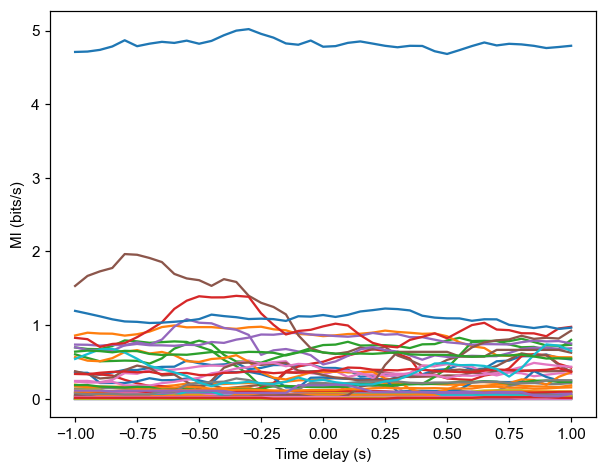

In [176]:
## plot out the MI trajectories
fig, ax = plt.subplots(dpi=110)
ax.plot(t_delay_arr, mi_delay_time_ca3)
ax.set_ylabel('MI (bits/s)')
ax.set_xlabel('Time delay (s)')

In [232]:
## CA1: create a matrix: mi_delay_time (length of t_delay_arr x #neurons)
## Find mi for each time delay
## find the max information
## use the p_val matrix to see if that max info is stastically significant

# load the data
ca1_param_df = pd.read_csv(FIL_DATA_PATH+'ec014_ca1_bootstrap_fit_params.csv')

# remove the bad cells
ca1_param_df = ca1_param_df.loc[ca1_param_df['sd'] > 0].loc[ca1_param_df['sd'] != np.inf]

# convert to an array
ca1_param_arr = ca1_param_df.to_numpy()
# ca1_param_arr

# delay time array
t_delay_arr = np.arange(-1, 1.05, 50e-3)
t_delay_arr = np.round(t_delay_arr, 3)

# create p-value array
mi_delay_time_ca1 = np.empty((len(t_delay_arr), ca1_param_arr.shape[0]))

for i, t in enumerate(t_delay_arr):
    for j, n in enumerate(ca1_param_arr[:, 0]):
        # find information for the time delay
        rx, px, binsx = firing_rate_location_data('ec014', np.int16(n+1), 4, 4, t)

        # find skaggs information
        mi_delay = skaggs_MI(rx, px)

        # append to the array
        mi_delay_time_ca1[i, j] = mi_delay

## save the array as npy file
np.save(FIL_DATA_PATH+'mi_delays_ca1_7_26_23.npy', mi_delay_time_ca3)
mi_delay_time_ca3

array([[0.        , 0.19053958, 0.60273249, ..., 0.6391155 , 0.01200794,
        0.11016548],
       [0.        , 0.1718905 , 0.55377904, ..., 0.65333966, 0.01200794,
        0.11008545],
       [0.        , 0.16398221, 0.50817245, ..., 0.646759  , 0.01200794,
        0.10999489],
       ...,
       [0.        , 0.16433735, 0.66385652, ..., 0.54610618, 0.0208014 ,
        0.03307133],
       [0.        , 0.15815083, 0.67738418, ..., 0.54849655, 0.01227829,
        0.03307133],
       [0.        , 0.18154249, 0.7986726 , ..., 0.54588577, 0.01227829,
        0.06558287]])

Text(0.5, 0, 'Time delay (s)')

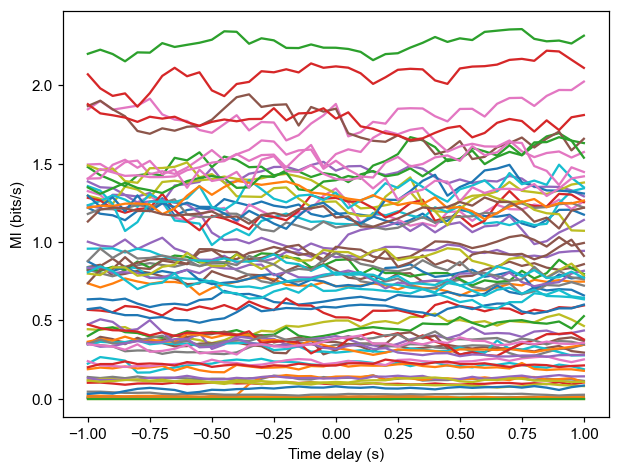

In [233]:
## plot out the MI trajectories
fig, ax = plt.subplots(dpi=110)
ax.plot(t_delay_arr, mi_delay_time_ca1)
ax.set_ylabel('MI (bits/s)')
ax.set_xlabel('Time delay (s)')

Number of neurons with stastically significant max MI = 26


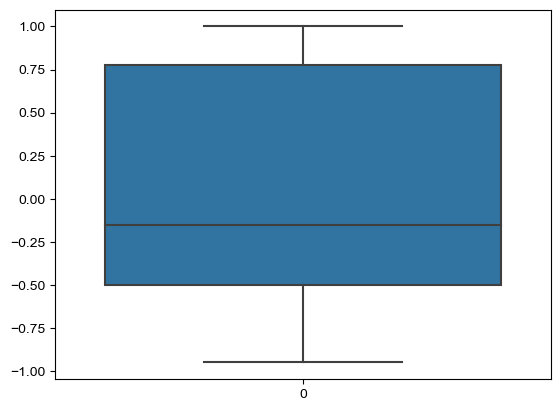

In [208]:
## CA3: find the delay times that give maximum statistically significant information
## test cases: 1. MI > 0 
##             2. MI should have p_value < 0.05
## make a t_d_max array: empty list (later convert to numpy if needed)

t_d_max_ca3 = []

for i, n in enumerate(ca3_param_arr[:, 0]):
    # for every column in mi_delay array find the argmax
    id_max = np.argmax(mi_delay_time_ca3[:, i])

    # check the p-value
    p_val = p_val_ca3[id_max, i]

    # extract max MI
    max_mi = mi_delay_time_ca3[id_max, i]

    if p_val < 0.05 and max_mi > 0:
        t_d_max_ca3.append(t_delay_arr[id_max])
    else:
        pass

sns.boxplot(t_d_max_ca3)

print(f'Number of neurons with stastically significant max MI = {len(t_d_max_ca3)}')

Number of neurons with stastically significant max MI = 26


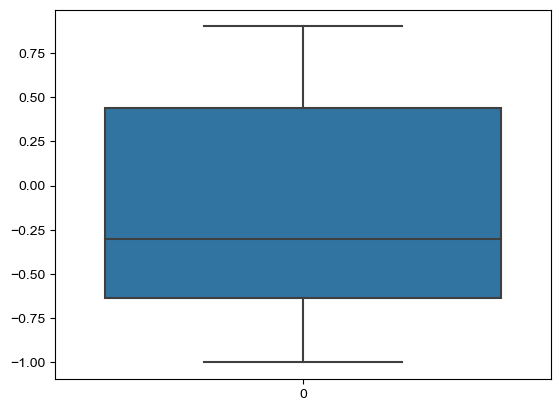

In [236]:
## CA1: find the delay times that give maximum statistically significant information
## test cases: 1. MI > 0 
##             2. MI should have p_value < 0.05
## make a t_d_max array: empty list (later convert to numpy if needed)

t_d_max_ca1 = []

for i, n in enumerate(ca1_param_arr[:, 0]):
    # for every column in mi_delay array find the argmax
    id_max = np.argmax(mi_delay_time_ca1[:, i])

    # check the p-value
    p_val = p_val_ca1[id_max, i]

    # extract max MI
    max_mi = mi_delay_time_ca1[id_max, i]

    if p_val < 0.05 and max_mi > 0:
        t_d_max_ca1.append(t_delay_arr[id_max])
    else:
        pass

sns.boxplot(t_d_max_ca1)

print(f'Number of neurons with stastically significant max MI = {len(t_d_max_ca1)}')

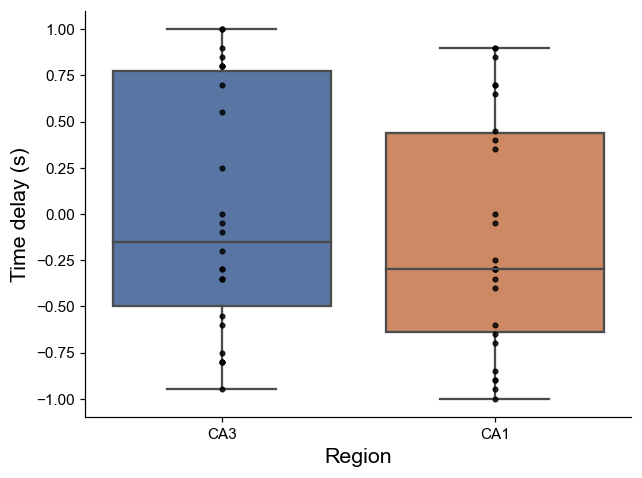

In [249]:
## plotting
pal_deep = sns.color_palette('deep')
data = np.stack((t_d_max_ca3, t_d_max_ca1))
fig, ax = plt.subplots(dpi=110)
sns.boxplot(data.T, palette=pal_deep)
ax.plot(np.ones_like(t_d_max_ca3)*0, t_d_max_ca3 , '.k', alpha=.8)
ax.plot(np.ones_like(t_d_max_ca1)*1, t_d_max_ca1 , '.k', alpha=.8)
ax.set_ylabel('Time delay (s)', fontsize=14)
ax.set_xlabel('Region', fontsize=14)
ax.set_xticklabels(['CA3', 'CA1'])

sns.despine()


In [253]:
## Mann Whitney U-Test:
## to find if two numpy vectors have different distributions
## Answering the question: Do the delays in CA3 and CA1 show stastical difference?

from scipy.stats import mannwhitneyu

# perform Mann, Whitney test
U_statistic, p_value = mannwhitneyu(t_d_max_ca1, t_d_max_ca3, alternative='two-sided')
print(f'p-value of Mann-Whitney U-Test = {p_value : 0.4f}')
# significance level : 0.05
# check if p-value is less than significance level
if p_value < 0.05:
    print('The distributions of two vectors are significantly different')

else:
    print('The distributions of the two vectors are not significantly different')

p-value of Mann-Whitney U-Test =  0.4469
The distributions of the two vectors are not significantly different


In [254]:
## printing out the median delays
print(f'Median delay in CA3 = {np.median(t_d_max_ca3) : .03f} s')
print(f'Median delay in CA1 = {np.median(t_d_max_ca1) : .03f} s')


Median delay in CA3 = -0.150 s
Median delay in CA1 = -0.300 s


# Observations
1. The median delay for max information in CA3 seems to be -150 ms.
1. After considering the neurons with statistically significant max MI values, we only find 26 out of the 64 neurons in the dataset to give statistical significance.
1. Similarly the median delay in CA1 seems to be -300 ms.
1. There are surprisingly also only 26 out of 71 neurons in the dataset for CA1 giving statistically significant mutual information.
1. Note that the negative sign implies that the spike output comes AFTER the location input.
1. This makes sense, as there are sensory delays involved downstream to the hippocampus.
1. Interestingly, the delay in CA1 seems to be almost double than that in CA3.
1. The data we have didn't give statistical significance on the *Mann-Whitney U-Test* to find if the distributions of delays for max information in the CA3 and CA1 regions are indeed different. So it is for now inconclusive if the delays in CA3 and CA1 are indeed different

# TESTING ...


In [246]:
tt = np.stack((t_d_max_ca1, t_d_max_ca3))
tt.shape

(2, 26)

In [116]:
rx, px, bins = firing_rate_location_data('gor01', 3, 4, 4, 7)
print(skaggs_MI(rx, px))

1.1387247742469835


In [126]:
1 - gauss.cdf(0.09, loc=0.09, scale=0.03)

0.5

In [140]:
np.int16(ca3_param_arr[:,0])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 19,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58,
       59, 60, 61, 62], dtype=int16)

In [222]:
bootstrap_arr_ca1 = np.genfromtxt('ca1_bootstrap_data_7_24_23.csv', delimiter=',')
bootstrap_arr_ca1

array([[ 1.63065875,  0.12328307,  1.20845981, ...,  1.58687783,
         0.43629389,  8.6396814 ],
       [ 1.27405288,  0.11692665,  1.41126576, ...,  1.75689126,
         0.45345244, 16.7395536 ],
       [ 1.36072432,  0.11053565,  1.71789829, ...,  1.75374461,
         0.46650248,  6.9421338 ],
       ...,
       [ 1.66496454,  0.12569303,  0.95375346, ...,  1.45166864,
         0.4411653 , 31.44555393],
       [ 1.61499719,  0.14368446,  1.23043901, ...,  1.27277449,
         0.39254811, 47.36102451],
       [ 1.49747656,  0.13561273,  2.00151616, ...,  1.61202581,
         0.51307443, 62.25095534]])